<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/VRT_(Video_Restoration_Transformer)_demo_on_UBFC_compressed_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab is adapted from the VRT Online Demo on Video Restoration (see below for details) to run on compressed UBFC-rPPG data.

It first preprocesses the UBFC (compressed using mp4v compression)
- uses OpenCV libraries to first detect the face using Haar-Cascade
- Crops and resizes the video to the settings specified in config (72 X 72)
- Generates .png files for the frames in the video and stores them in the input folder format that the VRT model needs
- Runs the VRT model on the input. Results are stored as .png files in results folder
- Converts the result .png sequence to .mp4 video file and stores it in the output directory on the drive

# VRT Online Demo on Video Restoration

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2201.12288)
[![GitHub Stars](https://img.shields.io/github/stars/JingyunLiang/VRT?style=social)](https://github.com/JingyunLiang/VRT)
[![download](https://img.shields.io/github/downloads/JingyunLiang/VRT/total.svg)](https://github.com/JingyunLiang/VRT/releases)
![visitors](https://visitor-badge.glitch.me/badge?page_id=jingyunliang/VRT)

This is a **VRT online demo on Video Restoration** of our paper [''VRT: A Video Restoration Transformer''](https://arxiv.org/abs/2201.12288).

VRT ahcieves state-of-the-art performance **(up to 2.16dB)** in
- video SR (REDS, Vimeo90K, Vid4 and UDM10)
- video deblurring (GoPro, DVD and REDS)
- video denoising (DAVIS and Set8)
- video frame interpolation (Vimeo90K, UCF101, DAVIS)
- space-time video SR (Vimeo90K, Vid4)

<img src="https://raw.githubusercontent.com/JingyunLiang/VRT/main/assets/vsr_visual.jpeg" width="100%">
<img src="https://raw.githubusercontent.com/JingyunLiang/VRT/main/assets/vdb_visual.jpeg" width="100%">



# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [1]:
!rm -r VRT
# Clone VRT
!git clone https://github.com/JingyunLiang/VRT.git
%cd VRT
!pip install -r requirements.txt
!pip install -q mediapy

rm: cannot remove 'VRT': No such file or directory
Cloning into 'VRT'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 99 (delta 21), reused 3 (delta 3), pack-reused 70 (from 1)
Receiving objects: 100% (99/99), 13.06 MiB | 33.95 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/VRT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [49]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive

drive.mount('/content/drive')
# change this to point to the compressed data folder
FILE_PATH = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_100_1_test/subject1' # @param {type: "string"}
FILE_NAME = 'vid.mp4' # @param {type: "string"}
!ls -l {FILE_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 14008
-rw------- 1 root root    74262 Feb 22 03:00 ground_truth.txt
-rw------- 1 root root 14268647 Feb 22 03:00 vid.mp4


# 2. Process Videos to be processed by VRT

Read UBFC-rPPG compressed video from drive and store as frames for processing by VRT.

In [1]:
import os
import mediapy as media

path = os.path.join(FILE_PATH,FILE_NAME)
video = media.read_video(path)
media.show_video(video, fps=30)

ModuleNotFoundError: No module named 'mediapy'

In [12]:
import os
import glob
from google.colab import files
import shutil
#print(' Note1: You can upload a single video/ video frames as a batch. \n Note2: If you just to want to replicate the results in the paper, you can skip this step (we have enabled automatic download in the code).\n Note3: You may need Chrome to enable file uploading!\n Note4: Our model is trained on simple synthetic videos (e.g., bicubic). It may not perform well on real-world videos.\n')
#input_folder = None

# upload images
!rm -r testsets/*
!rm -r results/*
dir_path = 'testsets'
if os.path.isdir(dir_path):
    print(f"Directory '{dir_path}' exists.")
else:
  os.mkdir(dir_path)
os.mkdir('testsets/uploaded')
#uploaded = files.upload()
#for filename in uploaded.keys():
#  is_image = (filename.split('.')[-1].lower() in ['png','jpeg','jpg','tiff','bmp','tif',])
#  input_folder = 'testsets/uploaded/000' if is_image else 'testsets/uploaded'
#  dst_path = os.path.join(input_folder, filename)
#  print(f'move {filename} to {dst_path}')
#  shutil.move(filename, dst_path)

#  if not is_image: # image or video
#    print(f'extracting the video as frames to {input_folder}/000')
#    os.system(f'ffmpeg -i testsets/uploaded/{filename} -qscale:v 1 -qmin 1 -qmax 1 -vsync 0  {input_folder}/000/frame%08d.png')
#    os.remove(f'testsets/uploaded/{filename}')

filename = "subject1_100_000_cropped_and_resized.mp4" # @param {type: "string"}

source_path = "/content/drive/MyDrive/research_project/data/preprocessed" # @param {type: "string"}
print("source path:")
!ls -l $source_path

input_folder = 'testsets/uploaded/000' # @param {type: "string"}
os.mkdir(input_folder)
shutil.copy(os.path.join(source_path, filename), input_folder)

print("Input folder: ")
!ls -l {input_folder}

dst_path = os.path.join(input_folder, filename)
print(f'extracting the video as frames to {input_folder}')
os.system(f'ffmpeg -i {input_folder}/{filename} -qscale:v 1 -qmin 1 -qmax 1 -vsync 0  {input_folder}/frame%08d.png')
os.remove(f'{input_folder}/{filename}')
!ls {input_folder}

Directory 'testsets' exists.
source path:
total 254
-rw------- 1 root root 259228 Mar  2 20:43 subject1_100_000_cropped_and_resized.mp4
Input folder: 
total 256
-rw------- 1 root root 259228 Mar  2 20:44 subject1_100_000_cropped_and_resized.mp4
extracting the video as frames to testsets/uploaded/000
frame00000001.png  frame00000311.png  frame00000621.png  frame00000931.png  frame00001241.png
frame00000002.png  frame00000312.png  frame00000622.png  frame00000932.png  frame00001242.png
frame00000003.png  frame00000313.png  frame00000623.png  frame00000933.png  frame00001243.png
frame00000004.png  frame00000314.png  frame00000624.png  frame00000934.png  frame00001244.png
frame00000005.png  frame00000315.png  frame00000625.png  frame00000935.png  frame00001245.png
frame00000006.png  frame00000316.png  frame00000626.png  frame00000936.png  frame00001246.png
frame00000007.png  frame00000317.png  frame00000627.png  frame00000937.png  frame00001247.png
frame00000008.png  frame00000318.png  fra

# 3. Inference


In [13]:
# Testing arguments
# --task: 001_VRT_videosr_bi_REDS_6frames/
#         002_VRT_videosr_bi_REDS_16frames/
#         003_VRT_videosr_bi_Vimeo_7frames/
#         004_VRT_videosr_bd_Vimeo_7frames/
#         005_VRT_videodeblurring_DVD/
#         006_VRT_videodeblurring_GoPro/
#         007_VRT_videodeblurring_REDS/
#         008_VRT_videodenoising_DAVIS
# --folder_lq: path to low-quality videos. If you have uploaded your own video, it will use yours.
#              Otherwise, it will automatically download benchmark datasets and test on them.
# --folder_gt: path to ground-truth videos. No use for your own video. Only support benchmark datasets.
# --tile: temporal, height and width testing sizes. For example, [40,128,128] means testing the video as 40x128x128 video clips.
#         Reduce it if out-of-memory (at the expense of lower performance).
# --tile_overlap: tile overlapping size. No need to modify it.



##                                                ### Benchmak testing  ###
## Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper.
## Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.)

## 001, video sr trained on REDS (6 frames), tested on REDS4
#!python main_test_vrt.py --task 001_VRT_videosr_bi_REDS_6frames --folder_lq testsets/REDS4/sharp_bicubic --folder_gt testsets/REDS4/GT --tile 40 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 002, video sr trained on REDS (16 frames), tested on REDS4
# !python main_test_vrt.py --task 002_VRT_videosr_bi_REDS_16frames --folder_lq testsets/REDS4/sharp_bicubic --folder_gt testsets/REDS4/GT --tile 40 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 003, video sr trained on Vimeo (bicubic), tested on Vid4 and Vimeo
# !python main_test_vrt.py --task 003_VRT_videosr_bi_Vimeo_7frames --folder_lq testsets/Vid4/BIx4 --folder_gt testsets/Vid4/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2
# !python main_test_vrt.py --task 003_VRT_videosr_bi_Vimeo_7frames --folder_lq testsets/vimeo90k/vimeo_septuplet_matlabLRx4/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 8 0 0 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 004, video sr trained on Vimeo (blur-downsampling), tested on Vid4, UDM10 and Vimeo
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/Vid4/BDx4 --folder_gt testsets/Vid4/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/UDM10/BDx4 --folder_gt testsets/UDM10/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/vimeo90k/vimeo_septuplet_BDLRx4/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 8 0 0 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 005, video deblurring trained and tested on DVD
# !python main_test_vrt.py --task 005_VRT_videodeblurring_DVD --folder_lq testsets/DVD10/test_GT_blurred --folder_gt testsets/DVD10/test_GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 006, video deblurring trained and tested on GoPro
# !python main_test_vrt.py --task 006_VRT_videodeblurring_GoPro --folder_lq testsets/GoPro11/test_GT_blurred --folder_gt testsets/GoPro11/test_GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 007, video deblurring trained on REDS, tested on REDS4
# !python main_test_vrt.py --task 007_VRT_videodeblurring_REDS --folder_lq testsets/REDS4/blur --folder_gt testsets/REDS4/GT --tile 12 256 256 --tile_overlap 2 20 20


## 008, video denoising trained on DAVIS (noise level 0-50) and tested on Set8 and DAVIS
# !python main_test_vrt.py --task 008_VRT_videodenoising_DAVIS --sigma 10 --folder_lq testsets/Set8 --folder_gt testsets/Set8 --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 008_VRT_videodenoising_DAVIS --sigma 10  --folder_lq testsets/DAVIS-test --folder_gt testsets/DAVIS-test --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 009, video frame interpolation trained on Vimeo (single frame interpolation), tested on Viemo, UCF101 and DAVIS-train
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/vimeo90k/vimeo_septuplet/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 0 0 0 --tile_overlap 0 0 0 --num_workers 2 --save_result
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/UCF101 --folder_gt testsets/UCF101 --tile 0 0 0 --tile_overlap 0 0 0 --num_workers 2 --save_result
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/DAVIS-train --folder_gt testsets/DAVIS-train --tile 0 256 256 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 010, space-time video sr, using pretrained models from 003 and 009, tested on Vid4 and Viemo
# Please refer to 003 and 009


##                                       ### test your own video (no ground-truth) ###
!python main_test_vrt.py  --task 003_VRT_videosr_bi_Vimeo_7frames   --folder_lq testsets/uploaded --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
loading model from ./model_zoo/vrt/model_zoo/vrt/003_VRT_videosr_bi_Vimeo_7frames.pth
/content/VRT/main_test_vrt.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

# 4. Visualization

 Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper. 
 Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.



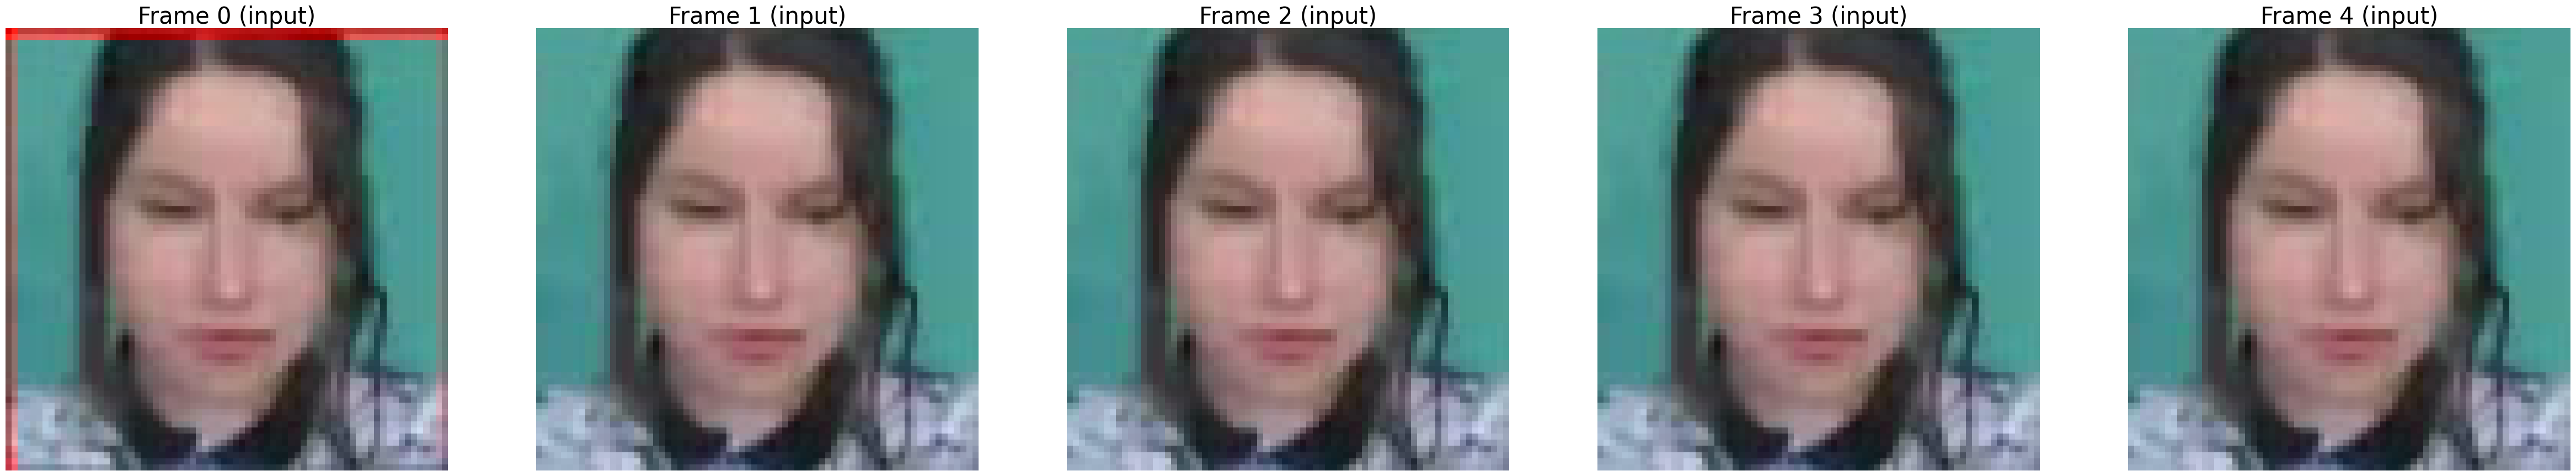

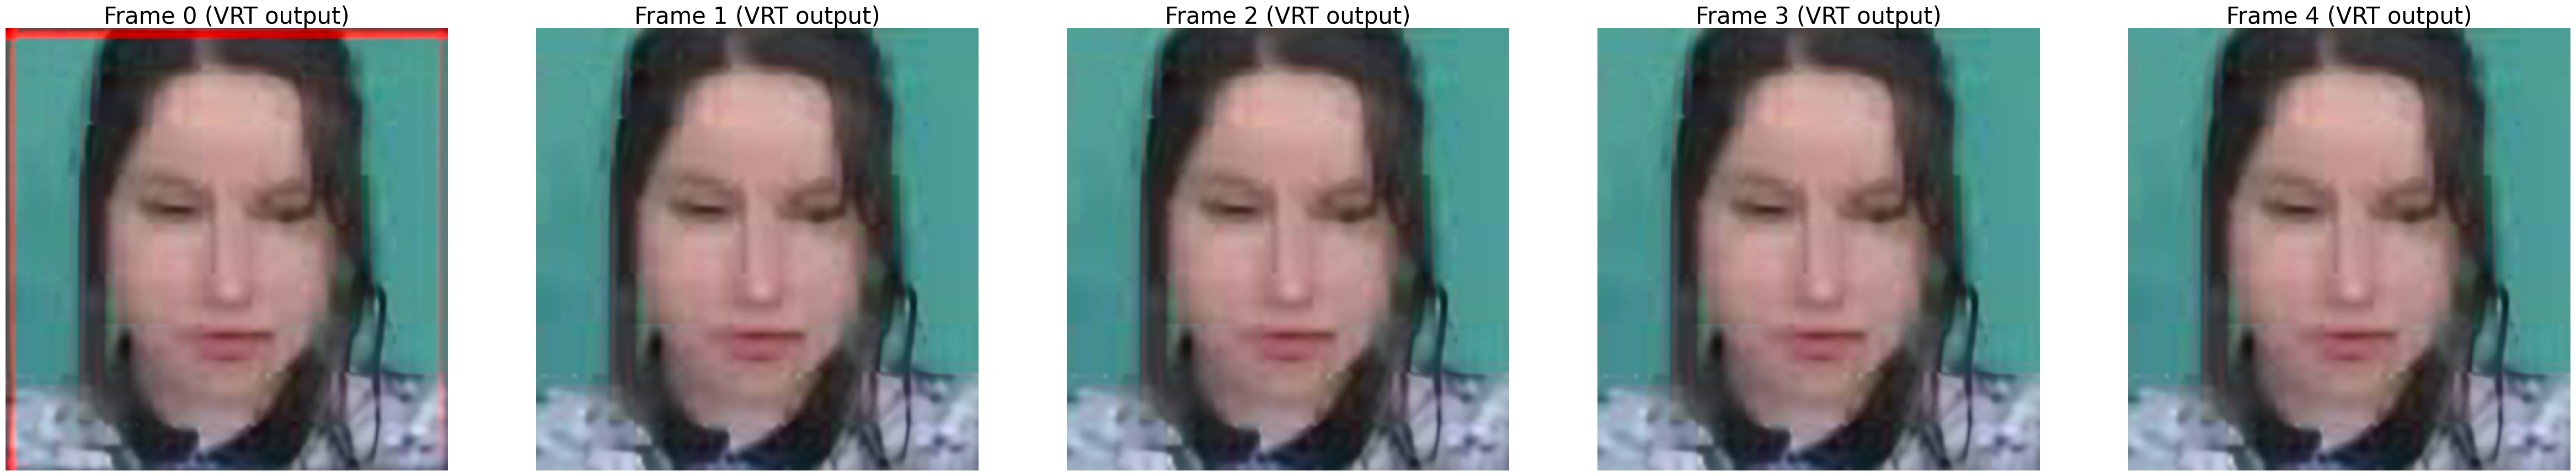

In [14]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def display(img1, name='input'):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title(f'Frame 0 ({name})', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title(f'Frame 1 ({name})', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title(f'Frame 2 ({name})', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title(f'Frame 3 ({name})', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title(f'Frame 4 ({name})', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1[0])
  ax2.imshow(img1[1])
  ax3.imshow(img1[2])
  ax4.imshow(img1[3])
  ax5.imshow(img1[4])

# display video by frames
print(' Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper. \n Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.\n')

img = []
for path in sorted(Path('testsets').rglob('*.png'))[:10]:
  img.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
display(img, 'input')
img = []
for path in sorted(Path('results').rglob('*.png'))[:10]:
  img.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
display(img, 'VRT output')

# 5. Download Results


In [33]:
import cv2
import os

def png_to_mp4(image_folder, output_path, fps=30, width=72, height=72):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    if not images:
        print("No PNG images found in the specified folder.")
        return

    first_image = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = first_image.shape
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in sorted(images):
        video_path = os.path.join(image_folder, image)
        frame = cv2.imread(video_path)
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()
    print(f"Video saved as {output_path} successfully")

RESULTS_PATH = '/content/VRT/results/003_VRT_videosr_bi_Vimeo_7frames/000' # @param {type: "string"}
FILE_NAME = "subject1_100_000_003_VRT_videosr_bi_Vimeo_7frames.mp4" # @param {type: "string"}
OUTPUT_PATH = "/content/drive/MyDrive/research_project/data/preprocessed" # @param {type: "string"}
WIDTH= 72 # @param {type: "number"}
HEIGHT= 72 # @param {type: "number"}
FPS= 30 # @param {type: "number"}
png_to_mp4(image_folder=RESULTS_PATH, output_path=os.path.join(OUTPUT_PATH, FILE_NAME), fps=FPS, width=WIDTH, height=HEIGHT)

Video saved as /content/drive/MyDrive/research_project/data/preprocessed/subject1_100_000_003_VRT_videosr_bi_Vimeo_7frames.mp4 successfully


In [34]:
!pip install -q mediapy
import mediapy as media

#ORIGINAL_VIDEO_PATH = "/content/drive/MyDrive/research_project/data/preprocessed/" # @param {type: "string"}
#video1 = media.read_video(ORIGINAL_VIDEO_PATH)
#media.show_video(video1, fps=30)
video2 = media.read_video(os.path.join(OUTPUT_PATH, FILE_NAME))
media.show_video(video2, fps=30)